In [248]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn import preprocessing, metrics
import pandas as pd
import numpy as np
from itertools import combinations

## Load and process the embeddings

In [249]:
# grab data

# file = 'data/full_final_layer_lda.csv'
file = 'data/full_layer_1_lda.csv'

rows=3804
# rows=1000


song_lbls = ['title', 'artist', 'lastfm_id', 'genius_id']
embedding_lbls = [str(i) for i in range(0, 768)]
other_lbls = ['feature_acousticness', 'feature_mode', 'feature_energy', 'feature_instrumentalness', 'feature_liveness', 'feature_valence', 'feature_loudness', 'feature_speechiness', 'feature_tempo', 'feature_key', 'feature_time_signature']
result_lbls = ['tag',] + [str(i) for i in np.arange(0.1, 7.1, 1)]

bert_df = pd.read_csv(file, nrows=rows, usecols=song_lbls + embedding_lbls + other_lbls)[song_lbls + embedding_lbls + other_lbls]

In [250]:
bert_df.head()

,title,artist,lastfm_id,genius_id,0,1,2,3,4,5,...,feature_mode,feature_energy,feature_instrumentalness,feature_liveness,feature_valence,feature_loudness,feature_speechiness,feature_tempo,feature_key,feature_time_signature
0,Rough Hands,Alexisonfire,TRQNBJV128F42972BF,199499.0,-0.186652,-0.269780,-0.867431,0.096107,-0.988871,0.325960,...,0.0,0.864,0.1140,0.1470,0.365,-6.371,0.0599,125.017,7.0,4.0
1,Fallin',Alicia Keys,TRIHMLE128F92F3F8C,344010.0,0.137911,-0.278991,1.251842,0.157736,0.305653,-0.181818,...,1.0,0.450,0.0000,0.0811,0.310,-11.049,0.0319,120.027,10.0,4.0
2,Goodbye,Alicia Keys,TRDTVQK128F4284EEC,149388.0,-0.003763,-0.084687,0.913970,0.018802,0.320332,0.290973,...,1.0,0.641,0.0000,0.1490,0.332,-4.339,0.0373,139.622,5.0,4.0
3,Sick And Tired,Anastacia,TRHDAOF128F4284873,808482.0,-0.034750,-0.731807,0.697732,0.020434,-0.289850,0.200330,...,0.0,0.282,0.0126,0.3300,0.156,-9.772,0.0312,146.580,9.0,4.0
4,Hold On,Angus & Julia Stone,TRIBPYT12903CB5C29,797364.0,0.504449,-0.648303,1.263850,-0.001091,0.343974,0.443290,...,1.0,0.471,0.0195,0.1050,0.230,-8.820,0.0358,124.850,9.0,4.0


In [251]:
first = 11
print('Bert Embeddings')

for x in embedding_lbls[:first]:
    print(x + "\n\tmean: " + str(np.mean(bert_df[x])) + "\n\tstd : " + str(np.std(bert_df[x])))
    print("\tmin : " + str(np.min(bert_df[x])) + "\n\tmax : " + str(np.max(bert_df[x])))
    print()

Bert Embeddings
0
	mean: -0.01658644539490878
	std : 0.18579566035467757
	min : -0.7364645000000001
	max : 0.9237767

1
	mean: -0.08718722336747134
	std : 0.24184647639173584
	min : -1.0957823
	max : 0.6609753

2
	mean: 0.1570132667153523
	std : 1.005189239609612
	min : -2.05618
	max : 1.9055036

3
	mean: -0.07651206303415878
	std : 0.20435996805339904
	min : -0.76315653
	max : 0.69464743

4
	mean: -0.06102896106704784
	std : 0.7167512111707112
	min : -2.1689005
	max : 1.3663301

5
	mean: 0.13872048738286513
	std : 0.2200680353496866
	min : -0.7859325
	max : 1.3567512

6
	mean: 0.1976090270522074
	std : 0.37704629147383906
	min : -0.5547025
	max : 1.3897431999999998

7
	mean: 0.07363770750045742
	std : 0.426575136015551
	min : -0.7360628
	max : 1.3495957

8
	mean: -0.051941492652897533
	std : 0.18389565742101088
	min : -0.8988181999999999
	max : 0.66060245

9
	mean: -0.2800656735490983
	std : 0.4353148035040778
	min : -1.1623663
	max : 1.0859739

10
	mean: -0.10831933867906678
	std : 0

In [252]:
'''
Categorical data that needs to be split:
    1. feature_key *12 total
    2. feature_time_signature * 4 total?

Data that needs to be normalized:
    1. all embedding layers
    2. feature_loudness
    3. feature_tempo
    4. feature_speechiness?? Don't do this one for now

'''
# one hot encoding on embeddings
t = 'feature_time_signature'
k = 'feature_key'
print(np.unique(bert_df[t]))
print(np.unique(bert_df[k]))

time_sig = pd.get_dummies(bert_df[t], prefix=t)
key = pd.get_dummies(bert_df[k], prefix=k)

bert_df = pd.concat([bert_df, time_sig, key], axis=1)

# drop the columns since they are split
bert_df.drop([t, k], axis=1, inplace=True)

other_features = [x for x in list(bert_df.columns.values) if x not in song_lbls + embedding_lbls]


# normalize embeddings and loudness and tempo
cols_to_norm = embedding_lbls + ['feature_loudness', 'feature_tempo']
bert_df[cols_to_norm] = bert_df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


# bert_df['feature_loudness']


[1. 3. 4. 5.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


In [257]:
bert_df.head()

,title,artist,lastfm_id,genius_id,0,1,2,3,4,5,...,feature_key_2.0,feature_key_3.0,feature_key_4.0,feature_key_5.0,feature_key_6.0,feature_key_7.0,feature_key_8.0,feature_key_9.0,feature_key_10.0,feature_key_11.0
0,Rough Hands,Alexisonfire,TRQNBJV128F42972BF,199499.0,0.331164,0.470185,0.300062,0.589423,0.333791,0.518925,...,0,0,0,0,0,1,0,0,0,0
1,Fallin',Alicia Keys,TRIHMLE128F92F3F8C,344010.0,0.526656,0.464942,0.835004,0.631699,0.699969,0.281943,...,0,0,0,0,0,0,0,0,1,0
2,Goodbye,Alicia Keys,TRDTVQK128F4284EEC,149388.0,0.441322,0.575546,0.749719,0.536395,0.704122,0.502597,...,0,0,0,1,0,0,0,0,0,0
3,Sick And Tired,Anastacia,TRHDAOF128F4284873,808482.0,0.422658,0.207186,0.695137,0.537515,0.531521,0.460293,...,0,0,0,0,0,0,0,1,0,0
4,Hold On,Angus & Julia Stone,TRIBPYT12903CB5C29,797364.0,0.747430,0.254719,0.838035,0.522749,0.710809,0.573684,...,0,0,0,0,0,0,0,1,0,0


## Reduce Dimensions

In [283]:
import umap
import umap.plot

# keep high dimensional structure in low dimension
# orignal embeddings has 767 features
embeddings = bert_df[features]


# for i in [0.5,0.6,0.7, 0.8]:
# for i in [2,5,10,50,100]:
#     print(i)
bert_umap = umap.UMAP(n_neighbors=20,
                 n_components=2,
                 min_dist = 0.65,
                 metric='euclidean').fit(embeddings)
umap_embeddings = bert_umap.transform(embeddings)

In [255]:
umap_df = pd.DataFrame(umap_embeddings)
umap_df.head()

,0,1,2,3,4,5,6,7,8,9
0,9.258349,6.227933,3.189712,6.778572,1.437401,5.290620,5.255725,6.824237,4.151570,5.615558
1,15.534700,7.077475,4.322853,5.430383,5.105409,4.537035,3.738596,6.424931,4.939888,4.818460
2,15.212849,6.781368,4.206449,5.741444,4.986366,4.746084,3.776444,6.494087,4.648216,4.620661
3,12.644728,6.750752,3.721071,6.173224,3.293488,4.987200,4.475554,7.004728,4.683238,5.000674
4,13.383765,6.537974,4.102815,6.082165,3.861706,5.132918,4.340912,7.008962,4.486661,4.900032


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


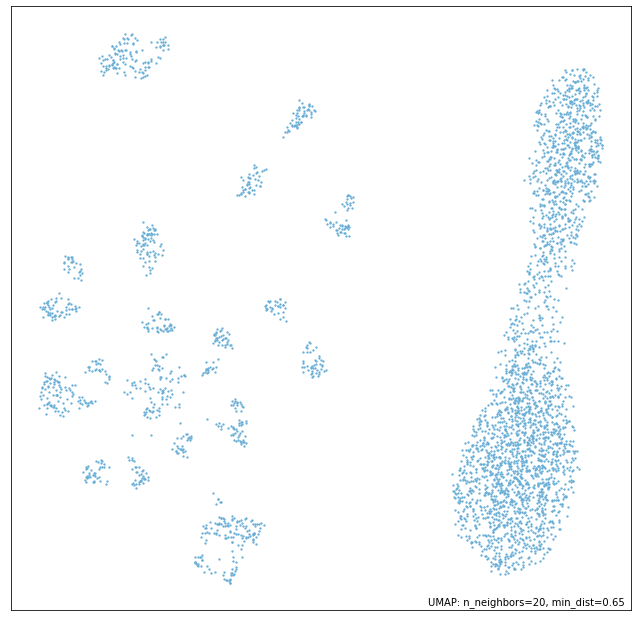

In [284]:
# print(umap_embeddings.shape)

umap.plot.points(bert_umap)
plt.show()

## Cluster w/DBSCAN

In [173]:
for i in np.linspace(1.0, 4.0, num=5):
    # Compute DBSCAN
    cluster = DBSCAN(eps=i, min_samples=2).fit(umap_embeddings)
    labels = cluster.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('epsilon:', i)
    print('Cluster shape:', len(labels))
    print('Estimated number of clusters: %d' % n_clusters_)
    unique, counts = np.unique(labels, return_counts=True)
    for i in range(len(unique)):
        if unique[i] == -1:
            print('\t Cluster NOISE count: {}'.format(counts[i]))
        else:
            print('\t Cluster {} count: {}'.format(unique[i], counts[i]))

    print('Estimated number of noise points: %d' % n_noise_)
    # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    # print("Adjusted Rand Index: %0.3f"
    #       % metrics.adjusted_rand_score(labels_true, labels))
    # print("Adjusted Mutual Information: %0.3f"
    #       % metrics.adjusted_mutual_info_score(labels_true, labels))
    try:
        print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(bert_df[embedding_lbls[:5]], labels))
    except:
        print("Silhouette Coefficient: Not valid.")
    print('\n\n')

epsilon: 1.0
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 329
	 Cluster 1 count: 671
Estimated number of noise points: 0
Silhouette Coefficient: 0.563



epsilon: 1.75
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 329
	 Cluster 1 count: 671
Estimated number of noise points: 0
Silhouette Coefficient: 0.563



epsilon: 2.5
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 329
	 Cluster 1 count: 671
Estimated number of noise points: 0
Silhouette Coefficient: 0.563



epsilon: 3.25
Cluster shape: 1000
Estimated number of clusters: 1
	 Cluster 0 count: 1000
Estimated number of noise points: 0
Silhouette Coefficient: Not valid.



epsilon: 4.0
Cluster shape: 1000
Estimated number of clusters: 1
	 Cluster 0 count: 1000
Estimated number of noise points: 0
Silhouette Coefficient: Not valid.





## Cluster w/HDBSCAN

In [91]:
import hdbscan
for i in [2,5,10,20,30,50,100]:
    cluster = hdbscan.HDBSCAN(min_cluster_size=i,
                              metric='euclidean',                      
                              cluster_selection_method='eom').fit(umap_embeddings)
    labels = cluster.labels_
    
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(cluster.labels_).count(-1)

    print('cluster size:', i)
    print('Cluster shape:', len(labels))
    print('Estimated number of clusters: %d' % n_clusters_)
    unique, counts = np.unique(labels, return_counts=True)
    for i in range(len(unique)):
        if unique[i] == -1:
            print('\t Cluster NOISE count: {}'.format(counts[i]))
        else:
            print('\t Cluster {} count: {}'.format(unique[i], counts[i]))

    print('Estimated number of noise points: %d' % n_noise_)
    try:
        print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(bert_df[embedding_lbls[:5]], labels))
    except:
        print("Silhouette Coefficient: Not valid.")
    print('\n\n')

cluster size: 2
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 316
	 Cluster 1 count: 684
Estimated number of noise points: 0
Silhouette Coefficient: 0.566



cluster size: 5
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 316
	 Cluster 1 count: 684
Estimated number of noise points: 0
Silhouette Coefficient: 0.566



cluster size: 10
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 684
	 Cluster 1 count: 316
Estimated number of noise points: 0
Silhouette Coefficient: 0.566



cluster size: 20
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 684
	 Cluster 1 count: 316
Estimated number of noise points: 0
Silhouette Coefficient: 0.566



cluster size: 30
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 count: 316
	 Cluster 1 count: 684
Estimated number of noise points: 0
Silhouette Coefficient: 0.566



cluster size: 50
Cluster shape: 1000
Estimated number of clusters: 2
	 Cluster 0 c

In [63]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(cluster.labels_).count(-1)

print('Cluster shape:', len(labels))
print('Estimated number of clusters: %d' % n_clusters_)
unique, counts = np.unique(cluster.labels_, return_counts=True)
for i in range(len(unique)):
    print('\t Cluster {} count: {}'.format(unique[i], counts[i]))

print('Estimated number of noise points: %d' % n_noise_)

Cluster shape: 3804
Estimated number of clusters: 2
	 Cluster 0 count: 2629
	 Cluster 1 count: 1175
Estimated number of noise points: 0


## Clustering With K Means

In [386]:
# for i in range(1,50):
cluster_count = 120

km = KMeans(
    n_clusters=cluster_count, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

labels = km.fit_predict(umap_df)  # prints the labels of each

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(cluster.labels_).count(-1)

print('cluster size:', i)
print('Cluster shape:', len(labels))
print('Estimated number of clusters: %d' % n_clusters_)
unique, counts = np.unique(labels, return_counts=True)
for i in range(len(unique)):
    if unique[i] == -1:
        print('\t Cluster NOISE count: {}'.format(counts[i]))
    else:
        print('\t Cluster {} count: {}'.format(unique[i], counts[i]))

# print('Estimated number of noise points: %d' % n_noise_)
try:
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(embeddings, labels))
except:
    print("Silhouette Coefficient: Not valid.")
print('\n\n')

cluster size: 302
Cluster shape: 3804
Estimated number of clusters: 120
	 Cluster 0 count: 27
	 Cluster 1 count: 32
	 Cluster 2 count: 32
	 Cluster 3 count: 43
	 Cluster 4 count: 74
	 Cluster 5 count: 45
	 Cluster 6 count: 55
	 Cluster 7 count: 46
	 Cluster 8 count: 34
	 Cluster 9 count: 34
	 Cluster 10 count: 44
	 Cluster 11 count: 57
	 Cluster 12 count: 44
	 Cluster 13 count: 32
	 Cluster 14 count: 19
	 Cluster 15 count: 45
	 Cluster 16 count: 35
	 Cluster 17 count: 28
	 Cluster 18 count: 39
	 Cluster 19 count: 38
	 Cluster 20 count: 44
	 Cluster 21 count: 28
	 Cluster 22 count: 23
	 Cluster 23 count: 26
	 Cluster 24 count: 31
	 Cluster 25 count: 23
	 Cluster 26 count: 27
	 Cluster 27 count: 30
	 Cluster 28 count: 35
	 Cluster 29 count: 24
	 Cluster 30 count: 34
	 Cluster 31 count: 27
	 Cluster 32 count: 55
	 Cluster 33 count: 36
	 Cluster 34 count: 30
	 Cluster 35 count: 58
	 Cluster 36 count: 16
	 Cluster 37 count: 51
	 Cluster 38 count: 35
	 Cluster 39 count: 41
	 Cluster 40 count

## Comparison Metric

In [336]:
# calculate distortion for a range of number of cluster
max_cluster = 310
distortions = []
silhouette = []
for i in range(2, max_cluster, 10):
    print('cluster: ', i)
    km = KMeans(
    n_clusters=i, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
    )

    labels = km.fit_predict(umap_df)  # prints the labels of each
    distortions.append(km.inertia_)
    print(km.inertia_)
    silhouette.append(metrics.silhouette_score(embeddings, labels))
    print(metrics.silhouette_score(embeddings, labels))
    print()


cluster:  2
103297.11788580257
0.2955100715672559

cluster:  12
7464.0274589933315
0.2120342191493151

cluster:  22
1810.3106029000724
0.11874987484905802

cluster:  32
1003.5882085481663
0.10239105651410292

cluster:  42
680.1628124917493
0.08297911419972198

cluster:  52
542.1757206291903
0.0799997181169265

cluster:  62
456.6619458848751
0.07239663525513079

cluster:  72
392.82920870608007
0.06919596514589312

cluster:  82
348.9452400899466
0.06908632032833956

cluster:  92
313.82910275362286
0.06546066492828091

cluster:  102
287.0582272737226
0.05764014585795742

cluster:  112
265.11191426396925
0.062016368654025794

cluster:  122
246.63867677220804
0.06240585915999985

cluster:  132
233.26245327551618
0.05894681697314713

cluster:  142
220.5456107380341
0.05340784068929909

cluster:  152
208.7347735362495
0.04948526160398032

cluster:  162
196.8351667566923
0.04534091529894929

cluster:  172
186.63492546782072
0.045152098377187914

cluster:  182
179.28900664800324
0.0450989468984

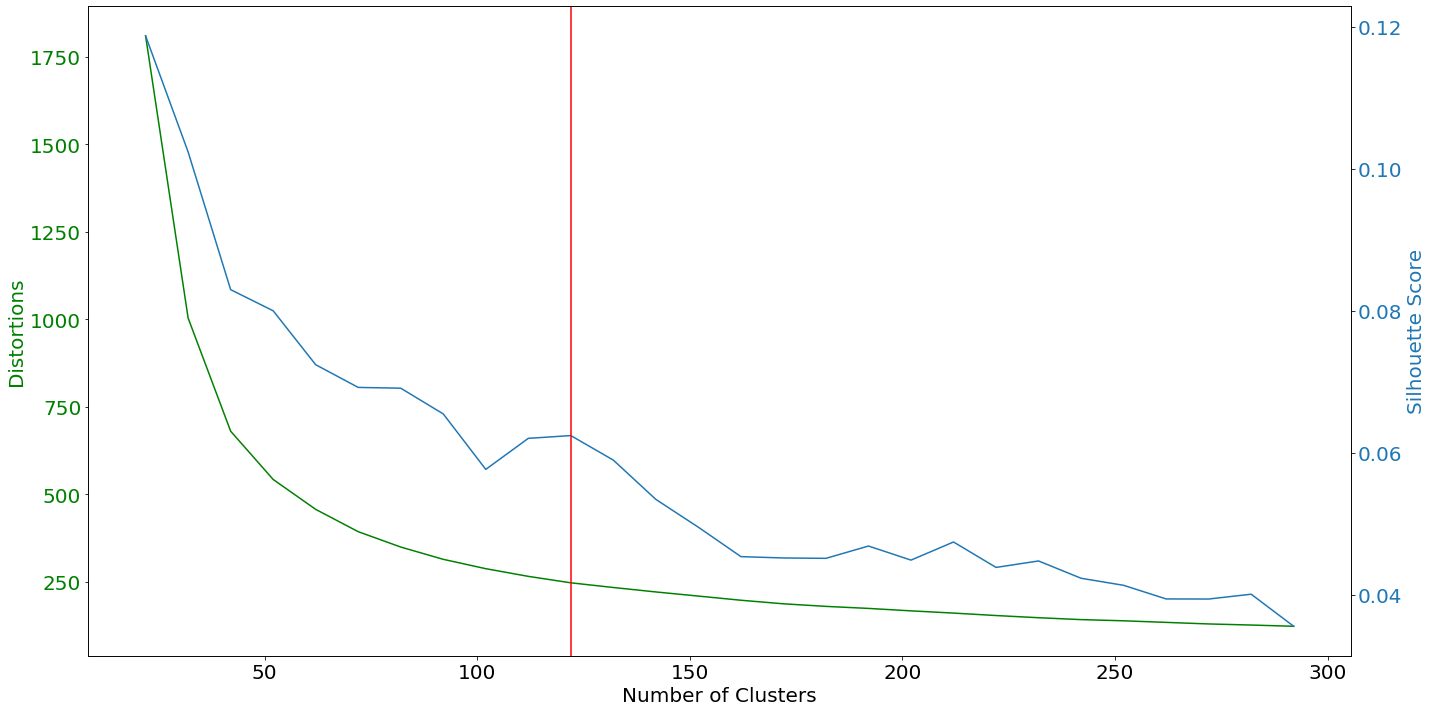

In [384]:
fs = 20

fig, ax1 = plt.subplots(figsize=(20, 10))

r1, r2 = [-29, -1]
x = list(range(2, max_cluster, 10))[r1:r2]

color = 'green'
ax1.set_xlabel('Number of Clusters', fontsize=fs)
ax1.set_ylabel('Distortions', color=color, fontsize=fs)
ax1.plot(x, distortions[r1:r2], color=color)
ax1.tick_params(axis='x', labelsize=fs)

ax1.tick_params(axis='y', labelcolor=color, labelsize=fs)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=fs)  # we already handled the x-label with ax1
ax2.plot(x, silhouette[r1:r2], color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=fs)

plt.axvline(x=122, c='r')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Results

In [387]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.65, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])

In [388]:
result['labels'] = labels   # grab labels from clustering

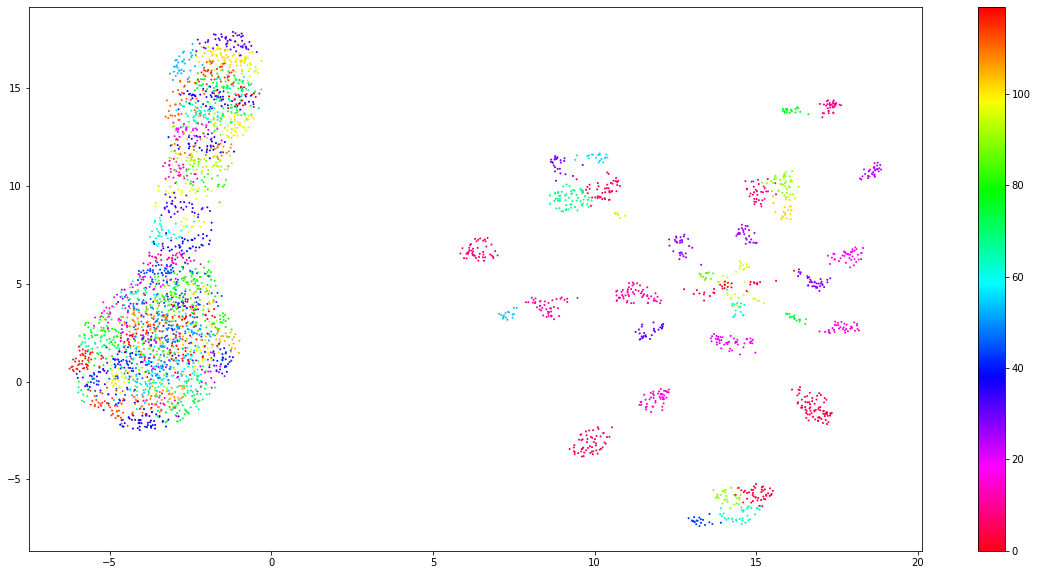

In [404]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
k = plt.colorbar()

## Outputs

In [405]:
c = 12 # 0, 55

print(len(np.where(labels == c)[0]))


print(np.where(labels == c)[0])

# for i in range(len(np.where(labels == c)[0])):
#     print(bert_df.loc[np.where(labels == c)[0][i], 'urlSpotify']) 

bert_df.loc[np.where(labels == c)[0]]

44
[2673 2712 2741 2745 2807 2817 2863 2864 2865 2869 2922 2934 2946 2982
 2985 2988 3017 3026 3051 3054 3104 3110 3224 3275 3286 3363 3432 3516
 3519 3523 3540 3557 3558 3571 3583 3597 3602 3624 3632 3636 3694 3703
 3743 3760]


title                 artist  \
2673                        Glory Days              Just Jack   
2712                The Saltwater Room               Owl City   
2741                       Spanish Air               Slowdive   
2745                Take Back The City            Snow Patrol   
2807                          Homeward            The Sundays   
2817                              Jump              Van Halen   
2863                              Cruz     Christina Aguilera   
2864                    Cold Tea Blues         Cowboy Junkies   
2865                     Hold On To Me         Cowboy Junkies   
2869                             Thumb           Dinosaur Jr.   
2922         Wait Til You See My Smile            Alicia Keys   
2934                 All Possibilities        Badly Drawn Boy   
2946                    So Here We Are             Bloc Party   
2982                     Blue Savannah                Erasure   
2985                          Get Gone            Fiona Apple   
2988                        '92 Subaru     Fountains Of Wayne   
3017                        California          Lenny Kravitz   
3026              Ocean Breathes Salty           Modest Mouse   
3051  I Think It's Going To Rain Today          Peter Gabriel   
3054                   Is This Desire?              PJ Harvey   
3104               Puttin' On The Ritz                   Taco   
3110                        Never Stop  The Brand New Heavies   
3224               The Trapeze Swinger            Iron & Wine   
3275                          Poor Boy             Nick Drake   
3286                    Umbrella Beach               Owl City   
3363                         If I Were          Vashti Bunyan   
3432            Do You Believe In Love  Huey Lewis & The News   
3516                        New Friend          The Concretes   
3519                 Then He Kissed Me           The Crystals   
3523              The Crane Wife 1 & 2       The Decemberists   
3540                              Soma  The Smashing Pumpkins   
3557                         Pessimist           Wild Nothing   
3558              Gettin' Jiggy Wit It             Will Smith   
3571                         Cataracts            Andrew Bird   
3583                 Another Sunny Day    Belle And Sebastian   
3597            She'll Come Back To Me                   Cake   
3602                             Spies               Coldplay   
3624                      Baker Street         Gerry Rafferty   
3632        Things Can Only Get Better           Howard Jones   
3636                        Hallelujah           Jeff Buckley   
3694                     Million Faces           Paolo Nutini   
3703                    Lemon Meringue                    Poe   
3743                       Funny Funny                  Sweet   
3760                 A Cautionary Song       The Decemberists   

               lastfm_id  genius_id         0         1         2         3  \
2673  TRGMIAQ128EF351642   449056.0  0.462226  0.659862  0.439933  0.321289   
2712  TRNFVQI128F931BAEA   193796.0  0.508009  0.632650  0.471991  0.369267   
2741  TRYCHIO128F145BA26  1406207.0  0.488888  0.629300  0.465865  0.363346   
2745  TRYFAJE128F92E0219  1009225.0  0.488391  0.612716  0.452343  0.407507   
2807  TRSLYZR128E07819EC  1378678.0  0.478166  0.605203  0.438217  0.364240   
2817  TRSXEHB128F92F4351   153749.0  0.490047  0.634874  0.447942  0.337646   
2863  TRBEAMO128F425B75F   204767.0  0.464140  0.591018  0.424534  0.357270   
2864  TRZUZDP128F93412E9  1678192.0  0.472082  0.637122  0.435472  0.339726   
2865  TRIUNCY128E0793E95  1346087.0  0.483066  0.582593  0.453398  0.327521   
2869  TRFMCJM128F148A1B2   189013.0  0.492983  0.613483  0.448973  0.358127   
2922  TRASHSN12903CA9E34   792828.0  0.499856  0.634383  0.457534  0.409863   
2934  TRBCCKG128F423EE6B  1045090.0  0.458172  0.624861  0.445022  0.360025   
2946  TRIVHEM128F931DBBE   426649.0  0.476559  0.639195  0.451814  0.374041   
2

## Save Results

In [392]:
save_df = bert_df[song_lbls].copy()

save_df['Group'] = labels   # grab labels from clustering

save_df.head()

,title,artist,lastfm_id,genius_id,Group
0,Rough Hands,Alexisonfire,TRQNBJV128F42972BF,199499.0,92
1,Fallin',Alicia Keys,TRIHMLE128F92F3F8C,344010.0,25
2,Goodbye,Alicia Keys,TRDTVQK128F4284EEC,149388.0,50
3,Sick And Tired,Anastacia,TRHDAOF128F4284873,808482.0,60
4,Hold On,Angus & Julia Stone,TRIBPYT12903CB5C29,797364.0,79


In [393]:
# save_df.to_csv('kmeans_groups.csv')

In [418]:
# song = save_df.loc[0]
# print(song.index)
save_df.loc[0, 'Group']

92